In [1]:
import networkx as nx
import pandas as pd
from matplotlib import pyplot, patches
from scipy import io
import numpy as np
from collections import defaultdict
import community
import pickle
from tqdm import tqdm
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt 
import glob, os
import csv
import scipy.stats as st
from tabulate import tabulate

C:\Users\wyw25\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\wyw25\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


# load the nullmodel data and structuralize

In [2]:
date="2018-01-31"
nulltype="EE"

In [3]:
def Make_dict_of_type(date,nulltype): #200*200=40000
    N_MODEL_dic={}
    Q_MODEL_dic={}
    I_MODEL_dic={}
    I_MQ_MODEL_dic={}
    for i in tqdm(range(200)):  # index for nullmodel
        N_dic={}
        Q_dic={}
        I_dic={}
        I_MQ_dic={}
        for j in range(200): # repeat times
            Address="C:/Users/wyw25/thesis/"+date+"_OUTPUT/"+nulltype+"/"+str(i)+"_nullindex/"+str(j)+"_repeat/data_structures_NQI_results"+date+".csv"
            df_output=pd.read_csv(Address)
            N_dic[j]=df_output['N'].values[0]
            Q_dic[j]=df_output['Q'].values[0]
            I_dic[j]=df_output['I'].values[0]
            I_MQ_dic[j]=df_output['I_MQ'].values[0]
        
        N_MODEL_dic[i]=N_dic
        Q_MODEL_dic[i]=Q_dic
        I_MODEL_dic[i]=I_dic
        I_MQ_MODEL_dic[i]=I_MQ_dic
        
    return  N_MODEL_dic,  Q_MODEL_dic, I_MODEL_dic, I_MQ_MODEL_dic
               

In [4]:
def Make_dict_of_date(date):
    EE={}
    FF={}
    PEEP={}
    PP={}
    
    N_MODEL_dic,  Q_MODEL_dic, I_MODEL_dic, I_MQ_MODEL_dic=Make_dict_of_type(date,"EE")
    EE['N']=N_MODEL_dic
    EE['Q']=Q_MODEL_dic
    EE['I']=I_MODEL_dic
    EE['I_MQ']=I_MQ_MODEL_dic
    
    N_MODEL_dic,  Q_MODEL_dic, I_MODEL_dic, I_MQ_MODEL_dic=Make_dict_of_type(date,"FF")
    FF['N']=N_MODEL_dic
    FF['Q']=Q_MODEL_dic
    FF['I']=I_MODEL_dic
    FF['I_MQ']=I_MQ_MODEL_dic
    
    N_MODEL_dic,  Q_MODEL_dic, I_MODEL_dic, I_MQ_MODEL_dic=Make_dict_of_type(date,"PEEP")
    PEEP['N']=N_MODEL_dic
    PEEP['I']=I_MODEL_dic
    PEEP['Q']=Q_MODEL_dic
    PEEP['I_MQ']=I_MQ_MODEL_dic
    
    N_MODEL_dic,  Q_MODEL_dic, I_MODEL_dic, I_MQ_MODEL_dic=Make_dict_of_type(date,"PP")
    PP['N']=N_MODEL_dic
    PP['Q']=Q_MODEL_dic
    PP['I']=I_MODEL_dic
    PP['I_MQ']=I_MQ_MODEL_dic
    
    
    return EE,FF,PEEP,PP
    
    

In [5]:
EE,FF,PEEP,PP=Make_dict_of_date("2018-01-31")

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [04:00<00:00,  1.20s/it]


# load the empirical data and structuralize

In [6]:
def Make_Empricial_data(date):
    N_dic={}
    Q_dic={}
    I_dic={}
    I_MQ_dic={}
    for i in range(200): # repeat times
        Address="C:/Users/wyw25/thesis/"+date+"/"+str(i)+"/data_structures_NQI_results"+date+".csv"
        df_output=pd.read_csv(Address)
        N_dic[i]=df_output['N'].values[0]
        Q_dic[i]=df_output['Q'].values[0]
        I_dic[i]=df_output['I'].values[0]
        I_MQ_dic[i]=df_output['I_MQ'].values[0]
            
    return  list(N_dic.values()),  list(Q_dic.values()), list(I_dic.values()), list(I_MQ_dic.values())

In [7]:
N_em,  Q_em, I_em, I_MQ_em=Make_Empricial_data("2018-01-31")

# Load data from server

In [8]:
datelist=['2018-01-16','2018-01-17',
            '2018-01-18','2018-01-19','2018-01-20','2018-01-21','2018-01-22','2018-01-23','2018-01-24',
            '2018-01-25','2018-01-26','2018-01-27','2018-01-28','2018-01-29','2018-01-30','2018-01-31', 
            '2018-02-01','2018-02-02','2018-02-03','2018-02-04','2018-02-05','2018-02-06','2018-02-07']

In [9]:
DATA_NULL={}
for date in datelist:
    with open("C:/Users/wyw25/thesis/to_local/"+date+"_stat.pkl", 'rb') as fp:
        parameters= pickle.load(fp)    
    DATA_NULL[date]=parameters

In [10]:
def Date_Slice_data(date,D):
    EE=D[date]['EE']
    FF=D[date]['FF']
    PEEP=D[date]['PEEP']
    PP=D[date]['PP']
    
    return EE,FF,PEEP,PP
    

In [11]:
DATA_EM={}
for date in datelist:
    with open("C:/Users/wyw25/thesis/em_to_local/"+date+"_stat.pkl", 'rb') as fp:
        parameters= pickle.load(fp)    
    DATA_EM[date]=parameters

In [12]:
def Date_Slice_EM(date,D):
    N_em=D[date]['N_em']
    Q_em=D[date]['Q_em']
    I_em=D[date]['I_em']
    I_MQ_em=D[date]['I_MQ_em']
    
    return N_em,  Q_em, I_em, I_MQ_em

# the functions for visualization

In [13]:
def Make_Gross_list(typedict):
    Gross_list=[]
    for variables in ['N','I','Q','I_MQ']: 
        numbers=[]
        for repeat in typedict[variables].keys():
            numbers=numbers+list(typedict[variables][repeat].values())
        Gross_list.append(numbers)   
            
    return Gross_list[0],Gross_list[1],Gross_list[2],Gross_list[3]
        

In [23]:
def Draw_means(data,position,Color,Label):
    sample_means = np.mean(data, axis=1)

    # Create a violin plot with the roles of x and y switched
    bp=plt.violinplot(data, showmeans=True, showextrema=False,positions=position,  widths=0.4)

    # Add a vertical line or point for the mean of each sample
    for i, mean_val in enumerate(sample_means):
        plt.plot(position[i], mean_val, 'k.')  # 'ro' stands for red color, round marker
        plt.text(position[i], mean_val+0.1,  "{:.2f}".format(mean_val), color='black', ha='center',fontsize=7)
        
    set_box_color(bp, Color)     
    
    return plt

In [31]:
def set_box_color(bp, color):
      #  plt.setp(bp['boxes'], color=color)
      #  plt.setp(bp['whiskers'], color=color)
       # plt.setp(bp['caps'], color=color)
   # plt.setp(bp['medians'], color=color)
    plt.setp(bp['bodies'], color=color)

def MAKE_violin(dataEE,dataFF,dataPEEP,dataPP,dataEMPIRICAL,ticks):    
    plt.figure(figsize=(5,5))

    bp1 = Draw_means(dataEE,np.array(range(len(dataEE)))*3.0-1.0,'tab:blue','EE')
    bp2 = Draw_means(dataFF,np.array(range(len(dataFF)))*3.0-0.5,'tab:orange','FF')
    bp3 = Draw_means(dataPEEP,np.array(range(len(dataPEEP)))*3.0,'tab:green','PEEP')
    bp4 = Draw_means(dataPP,np.array(range(len(dataPP)))*3.0+0.5,'tab:brown','PP')
    bp5 = Draw_means(dataEMPIRICAL,np.array(range(len(dataPP)))*3.0+1.0,'red','Empirical')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='tab:blue', label='EE')
    plt.plot([], c='tab:orange', label='FF')
    plt.plot([], c='tab:green', label='PEEP')
    plt.plot([], c='tab:brown', label='PP')
    plt.plot([], c='red', label='Empirical')
    plt.legend()
    
    plt.title('2018-01-23')
    plt.xticks(range(0, len(ticks) * 3, 3), ticks)
    #plt.xlim(-2, len(ticks)*3)
    plt.ylim(0, 1)
    plt.tight_layout()
    
    plt.savefig('figure1_3.pdf')

In [21]:
def Make_Plot_Of_Day(date,DATA_NULL,DATA_EM):
    # load the data on one day
    EE,FF,PEEP,PP=Date_Slice_data(date,DATA_NULL)
    N_em,  Q_em, I_em, I_MQ_em=Date_Slice_EM(date,DATA_EM) 

    # make gross list of the date
    N_EE,I_EE,Q_EE,I_MQ_EE=Make_Gross_list(EE)
    N_FF,I_FF,Q_FF,I_MQ_FF=Make_Gross_list(FF)
    N_PEEP,I_PEEP,Q_PEEP,I_MQ_PEEP=Make_Gross_list(PEEP)
    N_PP,I_PP,Q_PP,I_MQ_PP=Make_Gross_list(PP)

    # make list by types of nullmodel
    dataEE=[N_EE,I_EE,Q_EE,I_MQ_EE]
    dataFF=[N_FF,I_FF,Q_FF,I_MQ_FF]
    dataPEEP=[N_PEEP,I_PEEP,Q_PEEP,I_MQ_PEEP]
    dataPP=[N_PP,I_PP,Q_PP,I_MQ_PP]
    dataEMPIRICAL=[N_em,I_em,Q_em,I_MQ_em]

    ticks_NULL=['N','I','Q',r'$I_{MQ}$']

    # make list by types of indexs
    dataN=[N_EE,N_FF,N_PEEP,N_PP,N_em]
    dataI=[I_EE,I_FF,I_PEEP,I_PP,I_em]
    dataQ=[Q_EE,Q_FF,Q_PEEP,Q_PP,Q_em]
    dataIMQ=[I_MQ_EE,I_MQ_FF,I_MQ_PEEP,I_MQ_PP,I_MQ_em]

    ticks_INDEX=['EE','FF','PEEP','PP','EMPIRICAL']

    MAKE_violin(dataEE,dataFF,dataPEEP,dataPP,dataEMPIRICAL,ticks_NULL)


# Z and P values

In [210]:
def Z_P_score(list_em,list_null):
    n_em=len(list_em)
    n_null=len(list_null)
    em_bar=np.mean(list_em)
    null_bar=np.mean(list_null)
    em_std=np.std(list_em)
    null_std=np.std(list_null)
    
    z_scores=(em_bar-null_bar)/ (np.sqrt(null_std*null_std/n_null+em_std*em_std/n_em))
    p_values = st.norm.sf(abs(z_scores)) #one-sided
    
    return z_scores,p_values
    

In [211]:
def Make_Stat_Values(date,DATA_NULL,DATA_EM):
    EE,FF,PEEP,PP=Date_Slice_data(date,DATA_NULL)
    N_em,  Q_em, I_em, I_MQ_em=Date_Slice_EM(date,DATA_EM) 

    # make gross list of the date
    N_EE,I_EE,Q_EE,I_MQ_EE=Make_Gross_list(EE)
    N_FF,I_FF,Q_FF,I_MQ_FF=Make_Gross_list(FF)
    N_PEEP,I_PEEP,Q_PEEP,I_MQ_PEEP=Make_Gross_list(PEEP)
    N_PP,I_PP,Q_PP,I_MQ_PP=Make_Gross_list(PP)

    z_N_EE,p_N_EE=Z_P_score(N_em,N_EE)
    z_N_FF,p_N_FF=Z_P_score(N_em,N_FF)
    z_N_PEEP,p_N_PEEP=Z_P_score(N_em,N_PEEP)
    z_N_PP,p_N_PP=Z_P_score(N_em,N_PP)

    z_Q_EE,p_Q_EE=Z_P_score(Q_em,Q_EE)
    z_Q_FF,p_Q_FF=Z_P_score(Q_em,Q_FF)
    z_Q_PEEP,p_Q_PEEP=Z_P_score(Q_em,Q_PEEP)
    z_Q_PP,p_Q_PP=Z_P_score(Q_em,Q_PP)

    z_I_EE,p_I_EE=Z_P_score(I_em,I_EE)
    z_I_FF,p_I_FF=Z_P_score(I_em,I_FF)
    z_I_PEEP,p_I_PEEP=Z_P_score(I_em,I_PEEP)
    z_I_PP,p_I_PP=Z_P_score(I_em,I_PP)

    z_I_MQ_EE,p_I_MQ_EE=Z_P_score(I_MQ_em,I_MQ_EE)
    z_I_MQ_FF,p_I_MQ_FF=Z_P_score(I_MQ_em,I_MQ_FF)
    z_I_MQ_PEEP,p_I_MQ_PEEP=Z_P_score(I_MQ_em,I_MQ_PEEP)
    z_I_MQ_PP,p_I_MQ_PP=Z_P_score(I_MQ_em,I_MQ_PP)
    
    
    variable_names = ['N_EE', 'N_FF', 'N_PEEP', 'N_PP',
                  'Q_EE', 'Q_FF', 'Q_PEEP', 'Q_PP',
                  'I_EE', 'I_FF', 'I_PEEP', 'I_PP',
                  'I_MQ_EE', 'I_MQ_FF', 'I_MQ_PEEP', 'I_MQ_PP']

    
    z_scores = [z_N_EE, z_N_FF, z_N_PEEP, z_N_PP,
            z_Q_EE, z_Q_FF, z_Q_PEEP, z_Q_PP,
            z_I_EE, z_I_FF, z_I_PEEP, z_I_PP,
            z_I_MQ_EE, z_I_MQ_FF, z_I_MQ_PEEP, z_I_MQ_PP]

    p_values = [p_N_EE, p_N_FF, p_N_PEEP, p_N_PP,
            p_Q_EE, p_Q_FF, p_Q_PEEP, p_Q_PP,
            p_I_EE, p_I_FF, p_I_PEEP, p_I_PP,
            p_I_MQ_EE, p_I_MQ_FF, p_I_MQ_PEEP, p_I_MQ_PP]

   
    return   z_scores, p_values

In [220]:
z_scores={}
p_values={}
for date in datelist:
     z_scores[date], p_values[date]=Make_Stat_Values(date,DATA_NULL,DATA_EM)
    

In [221]:
z_N_EE=np.array(list(z_scores.values()))[:,0]
z_N_FF=np.array(list(z_scores.values()))[:,1]
z_N_PEEP=np.array(list(z_scores.values()))[:,2]
z_N_PP=np.array(list(z_scores.values()))[:,3]
z_Q_EE=np.array(list(z_scores.values()))[:,4]
z_Q_FF=np.array(list(z_scores.values()))[:,5]
z_Q_PEEP=np.array(list(z_scores.values()))[:,6]
z_Q_PP=np.array(list(z_scores.values()))[:,7]
z_I_EE=np.array(list(z_scores.values()))[:,8]
z_I_FF=np.array(list(z_scores.values()))[:,9]
z_I_PEEP=np.array(list(z_scores.values()))[:,10]
z_I_PP=np.array(list(z_scores.values()))[:,11]
z_I_MQ_EE=np.array(list(z_scores.values()))[:,12]
z_I_MQ_FF=np.array(list(z_scores.values()))[:,13]
z_I_MQ_PEEP=np.array(list(z_scores.values()))[:,14]
z_I_MQ_PP=np.array(list(z_scores.values()))[:,15]

p_N_EE=np.array(list(p_values.values()))[:,0]
p_N_FF=np.array(list(p_values.values()))[:,1]
p_N_PEEP=np.array(list(p_values.values()))[:,2]
p_N_PP=np.array(list(p_values.values()))[:,3]
p_Q_EE=np.array(list(p_values.values()))[:,4]
p_Q_FF=np.array(list(p_values.values()))[:,5]
p_Q_PEEP=np.array(list(p_values.values()))[:,6]
p_Q_PP=np.array(list(p_values.values()))[:,7]
p_I_EE=np.array(list(p_values.values()))[:,8]
p_I_FF=np.array(list(p_values.values()))[:,9]
p_I_PEEP=np.array(list(p_values.values()))[:,10]
p_I_PP=np.array(list(p_values.values()))[:,11]
p_I_MQ_EE=np.array(list(p_values.values()))[:,12]
p_I_MQ_FF=np.array(list(p_values.values()))[:,13]
p_I_MQ_PEEP=np.array(list(p_values.values()))[:,14]
p_I_MQ_PP=np.array(list(p_values.values()))[:,15]



In [223]:
z_Q_PP

array([ 16.2645855 ,          nan,  65.94311222, 129.24505154,
        68.09741752,  56.35234807,  80.78286865,  84.06959083,
       103.48215367,  85.1885096 , 100.31146255, 105.76871274,
       100.52837096, 107.67506806,  97.55158347, 113.31376684,
       119.6088345 , 111.97449624, 122.74383717, 118.42998015,
       124.00265459, 132.39850324, 158.42059673])

In [222]:
# Compute maximum and minimum of absolute values
max_abs_values = [np.max(np.abs(x)) for x in [z_N_EE, z_N_FF, z_N_PEEP, z_N_PP, z_Q_EE, z_Q_FF, z_Q_PEEP, z_Q_PP, z_I_EE, z_I_FF, z_I_PEEP, z_I_PP, z_I_MQ_EE, z_I_MQ_FF, z_I_MQ_PEEP, z_I_MQ_PP]]
min_abs_values = [np.min(np.abs(x)) for x in [z_N_EE, z_N_FF, z_N_PEEP, z_N_PP, z_Q_EE, z_Q_FF, z_Q_PEEP, z_Q_PP, z_I_EE, z_I_FF, z_I_PEEP, z_I_PP, z_I_MQ_EE, z_I_MQ_FF, z_I_MQ_PEEP, z_I_MQ_PP]]

print("Maximum absolute values:", max_abs_values)
print("Minimum absolute values:", min_abs_values)

Maximum absolute values: [22234.72614574809, 1747.2143227031804, 4171.975311699482, 1538.0220590733718, 74.94862229244372, 43.81842272728181, 90.2012047752052, nan, 105.96748300939711, 114.85662643542256, 82.2184121478686, 84.19242477418004, 137.65815991132857, 98.68486092587888, 146.25217891689147, 158.966953714653]
Minimum absolute values: [44.30883851490444, 152.51730385321886, 10.248441859213694, 24.841488410594017, 2.586882373757079, 2.1111659278643824, 1.6544180481135358, nan, 18.520146126943835, 15.803028042269235, 6.59908748201747, 1.5657819440933511, 1.1105084854185776, 13.825423080473731, 15.089392411566068, 17.47272260714116]


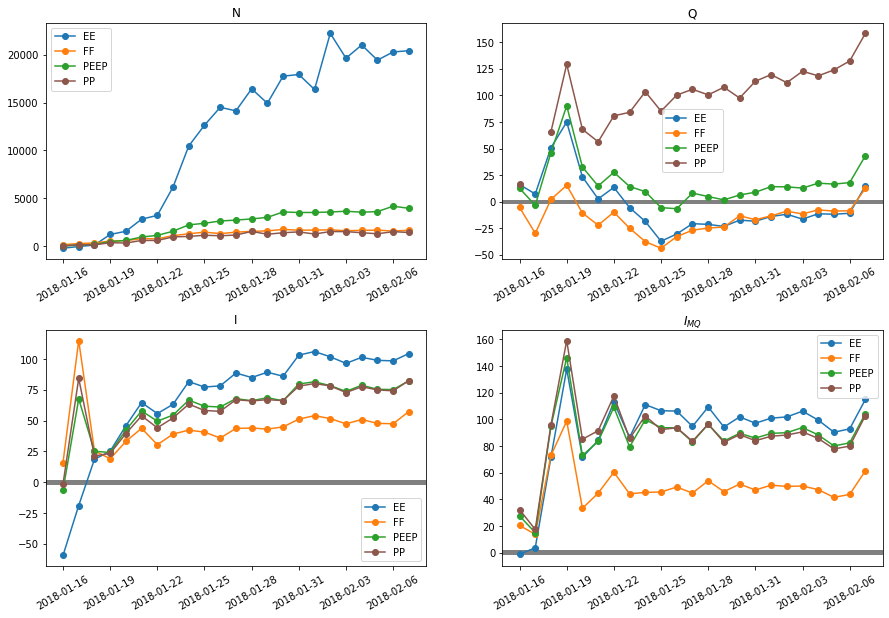

In [95]:
labels=datelist
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

axs[0, 0].plot(z_N_EE,'o-', color='tab:blue')
axs[0, 0].plot(z_N_FF, 'o-', color='tab:orange')
axs[0, 0].plot(z_N_PEEP,'o-', color='tab:green')
axs[0, 0].plot(z_N_PP, 'o-', color='tab:brown')
axs[0, 0].axhspan(-2, 2, facecolor='0.5')
axs[0, 0].set_title('N')
#axs[0, 0].set_ylim(0,8000)

axs[0, 1].plot(z_Q_EE, 'o-', color='tab:blue')
axs[0, 1].plot(z_Q_FF, 'o-', color='tab:orange')
axs[0, 1].plot(z_Q_PEEP, 'o-', color='tab:green')
axs[0, 1].plot(z_Q_PP,  'o-',color='tab:brown')
axs[0, 1].axhspan(-2, 2, facecolor='0.5')
axs[0, 1].set_title('Q')


axs[1, 0].plot(z_I_EE, 'o-', color='tab:blue')
axs[1, 0].plot(z_I_FF, 'o-', color='tab:orange')
axs[1, 0].plot(z_I_PEEP, 'o-', color='tab:green')
axs[1, 0].plot(z_I_PP, 'o-', color='tab:brown')
axs[1, 0].axhspan(-2, 2, facecolor='0.5')
axs[1, 0].set_title('I')

axs[1, 1].plot(z_I_MQ_EE,'o-',  color='tab:blue')
axs[1, 1].plot(z_I_MQ_FF, 'o-', color='tab:orange')
axs[1, 1].plot(z_I_MQ_PEEP,'o-',  color='tab:green')
axs[1, 1].plot(z_I_MQ_PP, 'o-',color='tab:brown')
axs[1, 1].axhspan(-2, 2, facecolor='0.5')
axs[1, 1].set_title(r'$I_{MQ}$')

for ax in axs.flat:
    ax.legend(['EE', 'FF', 'PEEP','PP'])
#    ax.set_xticks(np.arange(0, len(labels) ), labels=labels,rotation=30)
#    ax.set_yticklabels([])
    ax.set_xticks(np.arange(0, len(labels), step=3))
    ax.set_xticklabels(labels[::3], rotation=30)

fig.subplots_adjust(hspace=0.3)
plt.show()

In [214]:
# Compute percentages
percentages = {
    'N': {
        'EE': compute_percentage(z_N_EE),
        'FF': compute_percentage(z_N_FF),
        'PEEP': compute_percentage(z_N_PEEP),
        'PP': compute_percentage(z_N_PP)
    },
    'Q': {
        'EE': compute_percentage(z_Q_EE),
        'FF': compute_percentage(z_Q_FF),
        'PEEP': compute_percentage(z_Q_PEEP),
        'PP': compute_percentage(z_Q_PP)
    },
    'I': {
        'EE': compute_percentage(z_I_EE),
        'FF': compute_percentage(z_I_FF),
        'PEEP': compute_percentage(z_I_PEEP),
        'PP': compute_percentage(z_I_PP)
    },
    'I_MQ': {
        'EE': compute_percentage(z_I_MQ_EE),
        'FF': compute_percentage(z_I_MQ_FF),
        'PEEP': compute_percentage(z_I_MQ_PEEP),
        'PP': compute_percentage(z_I_MQ_PP)
    }
}

# Convert percentages to DataFrame
percentages_df = pd.DataFrame(percentages).T

# List of all z-score arrays and their labels
z_scores_list = [
    z_N_EE, z_N_FF, z_N_PEEP, z_N_PP, z_Q_EE, z_Q_FF, z_Q_PEEP, z_Q_PP,
    z_I_EE, z_I_FF, z_I_PEEP, z_I_PP, z_I_MQ_EE, z_I_MQ_FF, z_I_MQ_PEEP, z_I_MQ_PP
]
labels = [
    'N_EE', 'N_FF', 'N_PEEP', 'N_PP', 'Q_EE', 'Q_FF', 'Q_PEEP', 'Q_PP',
    'I_EE', 'I_FF', 'I_PEEP', 'I_PP', 'I_MQ_EE', 'I_MQ_FF', 'I_MQ_PEEP', 'I_MQ_PP'
]

# Initialize a DataFrame for the summary statistics
summary_df = pd.DataFrame(columns=[ 'Median', 'Min', 'Max'], index=labels)

# Compute statistics and p-values for each z-score array
for label, z in zip(labels, z_scores_list):
 #   mean = np.mean(z)
 #   std_dev = np.std(z)
    median = np.median(z)
    min_val = np.min(z)
    max_val = np.max(z)
 #   p_values = 2 * stats.norm.sf(np.abs(z))  # Two-tailed p-value
 #   mean_p_value = np.mean(p_values)  # Average p-value for the summary
    
    # Populate the summary DataFrame
    summary_df.loc[label] = [np.round(median, 2), np.round(min_val, 2), np.round(max_val, 2)]

# Combine summary statistics and percentages
combined_df = summary_df.join(percentages_df.stack().reset_index(level=1, name='Percentage').set_index('level_1'))
combined_df['Subcategory'] = combined_df.index
combined_df['Category'] = combined_df['Subcategory'].apply(lambda x: x.split('_')[0])
combined_df['Subcategory'] = combined_df['Subcategory'].apply(lambda x: x.split('_')[1])
combined_df = combined_df[['Category', 'Subcategory',  'Median', 'Min', 'Max', 'Percentage']]
combined_df = combined_df.reset_index(drop=True)

# Print the combined table
print(combined_df)

   Category Subcategory    Median     Min       Max  Percentage
0         N          EE  14503.99  -217.8  22234.73         NaN
1         N          FF   1460.31  152.52   1747.21         NaN
2         N        PEEP   2721.13   10.25   4171.98         NaN
3         N          PP   1156.84   24.84   1538.02         NaN
4         Q          EE    -11.84  -37.26     74.95         NaN
5         Q          FF    -13.29  -43.82     15.42         NaN
6         Q        PEEP     13.92   -6.64      90.2         NaN
7         Q          PP       NaN     NaN       NaN         NaN
8         I          EE      84.9  -59.48    105.97         NaN
9         I          FF     43.74    15.8    114.86         NaN
10        I        PEEP     66.55    -6.6     82.22         NaN
11        I          PP     66.15   -1.57     84.19         NaN
12        I          MQ     99.41   -1.11    137.66         NaN
13        I          MQ     47.05   13.83     98.68         NaN
14        I          MQ     89.42   15.0

In [199]:
# Function to compute percentage of values with abs(z) > 2.5

# Function to compute percentage of values with abs(z) > 2.5
def compute_percentage(z_scores_array):
    return np.sum(np.abs(z_scores_array) > 2.5) / len(z_scores_array) * 100

# Compute percentages
data = {
    'N': {
        'EE': compute_percentage(z_N_EE),
        'FF': compute_percentage(z_N_FF),
        'PEEP': compute_percentage(z_N_PEEP),
        'PP': compute_percentage(z_N_PP)
    },
    'Q': {
        'EE': compute_percentage(z_Q_EE),
        'FF': compute_percentage(z_Q_FF),
        'PEEP': compute_percentage(z_Q_PEEP),
        'PP': compute_percentage(z_Q_PP)
    },
    'I': {
        'EE': compute_percentage(z_I_EE),
        'FF': compute_percentage(z_I_FF),
        'PEEP': compute_percentage(z_I_PEEP),
        'PP': compute_percentage(z_I_PP)
    },
    'I_MQ': {
        'EE': compute_percentage(z_I_MQ_EE),
        'FF': compute_percentage(z_I_MQ_FF),
        'PEEP': compute_percentage(z_I_MQ_PEEP),
        'PP': compute_percentage(z_I_MQ_PP)
    }
}

# Convert to a DataFrame
df = pd.DataFrame(data).T
print(df)

              EE          FF        PEEP          PP
N     100.000000  100.000000  100.000000  100.000000
Q     100.000000   95.652174   95.652174   95.652174
I     100.000000  100.000000  100.000000   95.652174
I_MQ   95.652174  100.000000  100.000000  100.000000


In [194]:
import scipy.stats as stats
# List of all z-score arrays
# List of all z-score arrays and their labels
z_scores_list = [
    z_N_EE, z_N_FF, z_N_PEEP, z_N_PP, z_Q_EE, z_Q_FF, z_Q_PEEP, z_Q_PP,
    z_I_EE, z_I_FF, z_I_PEEP, z_I_PP, z_I_MQ_EE, z_I_MQ_FF, z_I_MQ_PEEP, z_I_MQ_PP
]
labels = [
    'z_N_EE', 'z_N_FF', 'z_N_PEEP', 'z_N_PP', 'z_Q_EE', 'z_Q_FF', 'z_Q_PEEP', 'z_Q_PP',
    'z_I_EE', 'z_I_FF', 'z_I_PEEP', 'z_I_PP', 'z_I_MQ_EE', 'z_I_MQ_FF', 'z_I_MQ_PEEP', 'z_I_MQ_PP'
]

# Initialize a DataFrame for the summary statistics
summary_df = pd.DataFrame(columns=['Mean', 'Std Dev', 'Median', 'Min', 'Max', 'p-value'], index=labels)

# Compute statistics and p-values for each z-score array
for label, z in zip(labels, z_scores_list):
    mean = np.mean(z)
    std_dev = np.std(z)
    median = np.median(z)
    min_val = np.min(z)
    max_val = np.max(z)
    p_values = 2 * stats.norm.sf(np.abs(z))  # Two-tailed p-value
    mean_p_value = np.mean(p_values)  # Average p-value for the summary
    
    # Populate the summary DataFrame
    summary_df.loc[label] = [mean, std_dev, median, min_val, max_val, mean_p_value]

# Print the summary table
print(summary_df)



                     Mean      Std Dev        Median         Min  \
z_N_EE       11871.093704  7871.031858  14503.987682 -217.800193   
z_N_FF        1221.319633   523.336908   1460.312995  152.517304   
z_N_PEEP      2343.017291  1367.929203   2721.128173   10.248442   
z_N_PP        1004.953056   499.366326   1156.836313   24.841488   
z_Q_EE          -2.882071    25.566218     -11.84495  -37.263751   
z_Q_FF         -15.308945    14.218829    -13.290629  -43.818423   
z_Q_PEEP        17.285956    20.343746     13.918748   -6.639863   
z_Q_PP                NaN          NaN           NaN         NaN   
z_I_EE          69.120925    41.453519     84.897366  -59.483387   
z_I_FF           44.45956    18.250382     43.735421   15.803028   
z_I_PEEP        60.685003    21.242902       66.5491   -6.599087   
z_I_PP          59.954372    21.493335     66.151201   -1.565782   
z_I_MQ_EE       91.042713    30.950333     99.407645   -1.110508   
z_I_MQ_FF       48.519328    15.932744     47.05

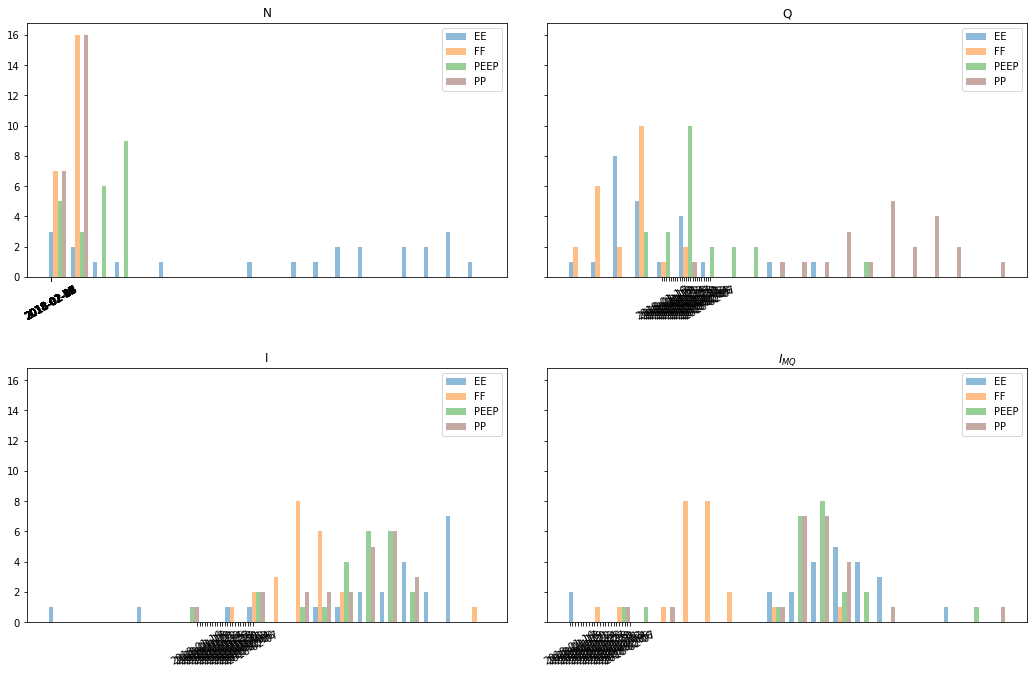

In [215]:
labels = datelist

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharey=True)

# Plot histograms
axs[0, 0].hist([z_N_EE, z_N_FF, z_N_PEEP, z_N_PP], bins=20, alpha=0.5, color=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown'], label=['EE', 'FF', 'PEEP', 'PP'])
axs[0, 0].set_title('N')
axs[0, 1].hist([z_Q_EE, z_Q_FF, z_Q_PEEP, z_Q_PP], bins=20, alpha=0.5, color=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown'], label=['EE', 'FF', 'PEEP', 'PP'])
axs[0, 1].set_title('Q')
axs[1, 0].hist([z_I_EE, z_I_FF, z_I_PEEP, z_I_PP], bins=20, alpha=0.5, color=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown'], label=['EE', 'FF', 'PEEP', 'PP'])
axs[1, 0].set_title('I')
axs[1, 1].hist([z_I_MQ_EE, z_I_MQ_FF, z_I_MQ_PEEP, z_I_MQ_PP], bins=20, alpha=0.5, color=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown'], label=['EE', 'FF', 'PEEP', 'PP'])
axs[1, 1].set_title(r'$I_{MQ}$')

# Set x-axis labels
for ax in axs.flat:
    ax.set_xticks(np.arange(0, len(labels), step=1))
    ax.set_xticklabels(labels, rotation=30)

# Set legend and adjust layout
for ax in axs.flat:
    ax.legend(loc='upper right')
fig.tight_layout(pad=3.0)

# Display plot
plt.show()

In [96]:
def Make_Plot_Of_Day(date, DATA_NULL, DATA_EM):
    # Load the data on one day
    EE, FF, PEEP, PP = Date_Slice_data(date, DATA_NULL)
    N_em, Q_em, I_em, I_MQ_em = Date_Slice_EM(date, DATA_EM)

    # Make gross list of the date
    N_EE, I_EE, Q_EE, I_MQ_EE = Make_Gross_list(EE)
    N_FF, I_FF, Q_FF, I_MQ_FF = Make_Gross_list(FF)
    N_PEEP, I_PEEP, Q_PEEP, I_MQ_PEEP = Make_Gross_list(PEEP)
    N_PP, I_PP, Q_PP, I_MQ_PP = Make_Gross_list(PP)

    # Make list by types of nullmodel
    dataEE = [N_EE, I_EE, Q_EE, I_MQ_EE]
    dataFF = [N_FF, I_FF, Q_FF, I_MQ_FF]
    dataPEEP = [N_PEEP, I_PEEP, Q_PEEP, I_MQ_PEEP]
    dataPP = [N_PP, I_PP, Q_PP, I_MQ_PP]
    dataEMPIRICAL = [N_em, I_em, Q_em, I_MQ_em]
    
    ticks_NULL=['N','I','Q',r'$I_{MQ}$']

    ticks_INDEX = ['EE', 'FF', 'PEEP', 'PP', 'EMPIRICAL']

    return dataEE, dataFF, dataPEEP, dataPP, dataEMPIRICAL, ticks_NULL

def MAKE_violin(dataEE, dataFF, dataPEEP, dataPP, dataEMPIRICAL, ticks):
    plt.figure(figsize=(6, 4))

    bp1 = Draw_means(dataEE, np.array(range(len(dataEE))) * 3.0 - 1.0, 'tab:blue', 'EE')
    bp2 = Draw_means(dataFF, np.array(range(len(dataFF))) * 3.0 - 0.5, 'tab:orange', 'FF')
    bp3 = Draw_means(dataPEEP, np.array(range(len(dataPEEP))) * 3.0, 'tab:green', 'PEEP')
    bp4 = Draw_means(dataPP, np.array(range(len(dataPP))) * 3.0 + 0.5, 'tab:brown', 'PP')
    bp5 = Draw_means(dataEMPIRICAL, np.array(range(len(dataEMPIRICAL))) * 3.0 + 1.0, 'red', 'Empirical')

    # Draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='tab:blue', label='EE')
    plt.plot([], c='tab:orange', label='FF')
    plt.plot([], c='tab:green', label='PEEP')
    plt.plot([], c='tab:brown', label='PP')
    plt.plot([], c='red', label='Empirical')
    plt.legend()

    plt.xticks(range(0, len(ticks) * 3, 3), ticks)
    plt.ylim(0, 1)
    plt.tight_layout()

def Make_Three_Date_Plot(date1, date2, date3, DATA_NULL, DATA_EM):
    # Get data for each date
    data1 = Make_Plot_Of_Day(date1, DATA_NULL, DATA_EM)
    data2 = Make_Plot_Of_Day(date2, DATA_NULL, DATA_EM)
    data3 = Make_Plot_Of_Day(date3, DATA_NULL, DATA_EM)

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Plot for date1
    plt.sca(axs[0])
    MAKE_violin(*data1)
    axs[0].set_title(f'Data - {date1}')

    # Plot for date2
    plt.sca(axs[1])
    MAKE_violin(*data2)
    axs[1].set_title(f'Data - {date2}')

    # Plot for date3
    plt.sca(axs[2])
    MAKE_violin(*data3)
    axs[2].set_title(f'Data - {date3}')

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()


In [52]:
def Draw_means(data, positions, color, label):
    parts = plt.violinplot(data, positions=positions, showmeans=False, showmedians=True)
    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor(color)
        pc.set_alpha(0.7)
    return parts

def Make_Plot_Of_Day(date, DATA_NULL, DATA_EM):
    # Load the data on one day
    EE, FF, PEEP, PP = Date_Slice_data(date, DATA_NULL)
    N_em, Q_em, I_em, I_MQ_em = Date_Slice_EM(date, DATA_EM)

    # Make gross list of the date
    N_EE, I_EE, Q_EE, I_MQ_EE = Make_Gross_list(EE)
    N_FF, I_FF, Q_FF, I_MQ_FF = Make_Gross_list(FF)
    N_PEEP, I_PEEP, Q_PEEP, I_MQ_PEEP = Make_Gross_list(PEEP)
    N_PP, I_PP, Q_PP, I_MQ_PP = Make_Gross_list(PP)

    # Make list by types of nullmodel
    dataEE = [N_EE, I_EE, Q_EE, I_MQ_EE]
    dataFF = [N_FF, I_FF, Q_FF, I_MQ_FF]
    dataPEEP = [N_PEEP, I_PEEP, Q_PEEP, I_MQ_PEEP]
    dataPP = [N_PP, I_PP, Q_PP, I_MQ_PP]
    dataEMPIRICAL = [N_em, I_em, Q_em, I_MQ_em]
    
    ticks_NULL=['N','I','Q','I_MQ']

    ticks_INDEX = ['EE', 'FF', 'PEEP', 'PP', 'EMPIRICAL']

    return dataEE, dataFF, dataPEEP, dataPP, dataEMPIRICAL, ticks_NULL

def MAKE_violin(ax, dataEE, dataFF, dataPEEP, dataPP, dataEMPIRICAL, ticks):
    bp1 = Draw_means(dataEE, np.array(range(len(dataEE))) * 3.0 - 1.0, 'tab:blue', 'EE')
    bp2 = Draw_means(dataFF, np.array(range(len(dataFF))) * 3.0 - 0.5, 'tab:orange', 'FF')
    bp3 = Draw_means(dataPEEP, np.array(range(len(dataPEEP))) * 3.0, 'tab:green', 'PEEP')
    bp4 = Draw_means(dataPP, np.array(range(len(dataPP))) * 3.0 + 0.5, 'tab:brown', 'PP')
    bp5 = Draw_means(dataEMPIRICAL, np.array(range(len(dataEMPIRICAL))) * 3.0 + 1.0, 'red', 'Empirical')

    # Draw temporary red and blue lines and use them to create a legend
    ax.plot([], c='tab:blue', label='EE')
    ax.plot([], c='tab:orange', label='FF')
    ax.plot([], c='tab:green', label='PEEP')
    ax.plot([], c='tab:brown', label='PP')
    ax.plot([], c='red', label='Empirical')
    ax.legend()

    ax.set_xticks(range(0, len(ticks) * 3, 3))
    ax.set_xticklabels(ticks)
    ax.set_ylim(0, 1)

def Make_Three_Date_Plot(date1, date2, date3, DATA_NULL, DATA_EM):
    # Get data for each date
    data1 = Make_Plot_Of_Day(date1, DATA_NULL, DATA_EM)
    data2 = Make_Plot_Of_Day(date2, DATA_NULL, DATA_EM)
    data3 = Make_Plot_Of_Day(date3, DATA_NULL, DATA_EM)

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Plot for date1
    MAKE_violin(axs[0], *data1)
    axs[0].set_title(f'Data - {date1}')
    axs[0].set_xlabel('Models')
    axs[0].set_ylabel('Values')

    # Plot for date2
    MAKE_violin(axs[1], *data2)
    axs[1].set_title(f'Data - {date2}')
    axs[1].set_xlabel('Models')
    axs[1].set_ylabel('Values')

    # Plot for date3
    MAKE_violin(axs[2], *data3)
    axs[2].set_title(f'Data - {date3}')
    axs[2].set_xlabel('Models')
    axs[2].set_ylabel('Values')

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

In [62]:
def Draw_means(data, positions, color, label):
    parts = plt.violinplot(data, positions=positions, showmeans=False, showmedians=True)
    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor(color)
        pc.set_alpha(0.7)
    return parts

def Make_Plot_Of_Day(date, DATA_NULL, DATA_EM):
    # Load the data on one day
    EE, FF, PEEP, PP = Date_Slice_data(date, DATA_NULL)
    N_em, Q_em, I_em, I_MQ_em = Date_Slice_EM(date, DATA_EM)

    # Make gross list of the date
    N_EE, I_EE, Q_EE, I_MQ_EE = Make_Gross_list(EE)
    N_FF, I_FF, Q_FF, I_MQ_FF = Make_Gross_list(FF)
    N_PEEP, I_PEEP, Q_PEEP, I_MQ_PEEP = Make_Gross_list(PEEP)
    N_PP, I_PP, Q_PP, I_MQ_PP = Make_Gross_list(PP)

    # Make list by types of nullmodel
    dataEE = [N_EE, I_EE, Q_EE, I_MQ_EE]
    dataFF = [N_FF, I_FF, Q_FF, I_MQ_FF]
    dataPEEP = [N_PEEP, I_PEEP, Q_PEEP, I_MQ_PEEP]
    dataPP = [N_PP, I_PP, Q_PP, I_MQ_PP]
    dataEMPIRICAL = [N_em, I_em, Q_em, I_MQ_em]
    
    ticks_NULL=['N','I','Q','I_MQ']

    ticks_INDEX = ['EE', 'FF', 'PEEP', 'PP', 'EMPIRICAL']

    return dataEE, dataFF, dataPEEP, dataPP, dataEMPIRICAL, ticks_NULL

def MAKE_violin(ax, date, DATA_NULL, DATA_EM):
    dataEE, dataFF, dataPEEP, dataPP, dataEMPIRICAL, ticks_INDEX = Make_Plot_Of_Day(date, DATA_NULL, DATA_EM)
    
    bp1 = Draw_means(dataEE, np.array(range(len(dataEE))) * 3.0 - 1.0, 'tab:blue', 'EE')
    bp2 = Draw_means(dataFF, np.array(range(len(dataFF))) * 3.0 - 0.5, 'tab:orange', 'FF')
    bp3 = Draw_means(dataPEEP, np.array(range(len(dataPEEP))) * 3.0, 'tab:green', 'PEEP')
    bp4 = Draw_means(dataPP, np.array(range(len(dataPP))) * 3.0 + 0.5, 'tab:brown', 'PP')
    bp5 = Draw_means(dataEMPIRICAL, np.array(range(len(dataEMPIRICAL))) * 3.0 + 1.0, 'red', 'Empirical')

    ax.plot([], c='tab:blue', label='EE')
    ax.plot([], c='tab:orange', label='FF')
    ax.plot([], c='tab:green', label='PEEP')
    ax.plot([], c='tab:brown', label='PP')
    ax.plot([], c='red', label='Empirical')
    ax.legend()

    ax.set_xticks(range(0, len(ticks_INDEX) * 3, 3))
    ax.set_xticklabels(ticks_INDEX)
    ax.set_ylim(0, 1)

def Make_Three_Date_Plot(date1, date2, date3, DATA_NULL, DATA_EM):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Plot for date1
    MAKE_violin(axs[0], date1, DATA_NULL, DATA_EM)
    axs[0].set_title(f'Data - {date1}')
    axs[0].set_xlabel('Models')
    axs[0].set_ylabel('Values')

    # Plot for date2
    MAKE_violin(axs[1], date2, DATA_NULL, DATA_EM)
    axs[1].set_title(f'Data - {date2}')
    axs[1].set_xlabel('Models')
    axs[1].set_ylabel('Values')

    # Plot for date3
    MAKE_violin(axs[2], date3, DATA_NULL, DATA_EM)
    axs[2].set_title(f'Data - {date3}')
    axs[2].set_xlabel('Models')
    axs[2].set_ylabel('Values')

    plt.tight_layout()
    plt.show()

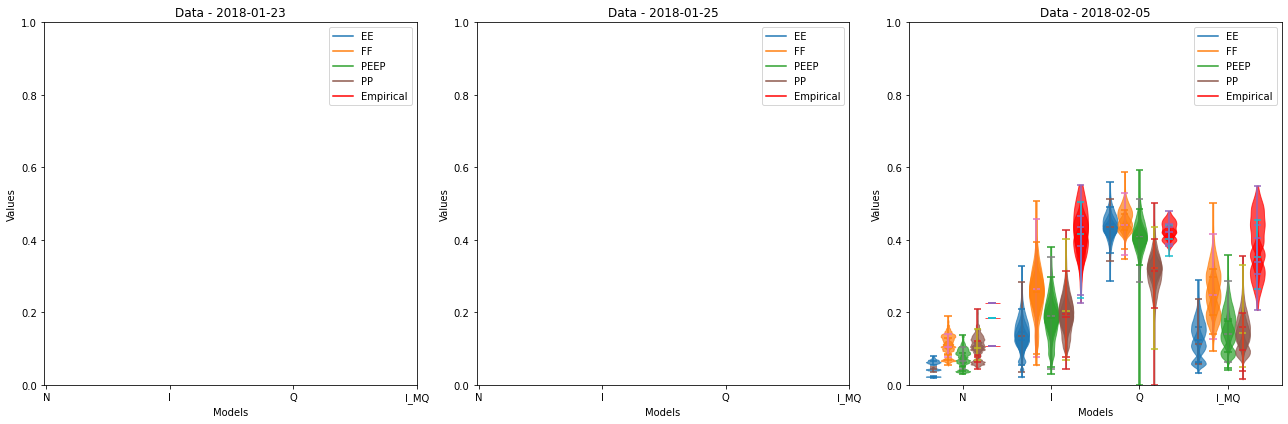

In [63]:
# Example usage
Make_Three_Date_Plot('2018-01-23', '2018-01-25', '2018-02-05', DATA_NULL, DATA_EM)

In [17]:
def Draw_means(data, position, Color, Label):
    sample_means = np.mean(data, axis=1)

    # Create a violin plot with the roles of x and y switched
    bp = plt.violinplot(data, showmeans=True, showextrema=False, positions=position, widths=0.4)

    # Add a vertical line or point for the mean of each sample
    for i, mean_val in enumerate(sample_means):
        plt.plot(position[i], mean_val, 'k.')  # 'ro' stands for red color, round marker
        plt.text(position[i], mean_val + 0.1, "{:.2f}".format(mean_val), color='black', ha='center', fontsize=7)

    set_box_color(bp, Color)

    return plt  

def MAKE_violin(dataEE, dataFF, dataPEEP, dataPP, dataEMPIRICAL, ticks):
    plt.figure(figsize=(6, 4))

    bp1 = Draw_means(dataEE, np.array(range(len(dataEE))) * 3.0 - 1.0, 'tab:blue', 'EE')
    bp2 = Draw_means(dataFF, np.array(range(len(dataFF))) * 3.0 - 0.5, 'tab:orange', 'FF')
    bp3 = Draw_means(dataPEEP, np.array(range(len(dataPEEP))) * 3.0, 'tab:green', 'PEEP')
    bp4 = Draw_means(dataPP, np.array(range(len(dataPP))) * 3.0 + 0.5, 'tab:brown', 'PP')
    bp5 = Draw_means(dataEMPIRICAL, np.array(range(len(dataPP))) * 3.0 + 1.0, 'red', 'Empirical')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='tab:blue', label='EE')
    plt.plot([], c='tab:orange', label='FF')
    plt.plot([], c='tab:green', label='PEEP')
    plt.plot([], c='tab:brown', label='PP')
    plt.plot([], c='red', label='Empirical')
    plt.legend()

    plt.xticks(range(0, len(ticks) * 3, 3), ticks)
    plt.ylim(0, 1)
    plt.tight_layout()

def Make_Plot_Of_Day(date, DATA_NULL, DATA_EM):
    EE, FF, PEEP, PP = Date_Slice_data(date, DATA_NULL)
    N_em, Q_em, I_em, I_MQ_em = Date_Slice_EM(date, DATA_EM) 

    N_EE, I_EE, Q_EE, I_MQ_EE = Make_Gross_list(EE)
    N_FF, I_FF, Q_FF, I_MQ_FF = Make_Gross_list(FF)
    N_PEEP, I_PEEP, Q_PEEP, I_MQ_PEEP = Make_Gross_list(PEEP)
    N_PP, I_PP, Q_PP, I_MQ_PP = Make_Gross_list(PP)

    dataEE = [N_EE, I_EE, Q_EE, I_MQ_EE]
    dataFF = [N_FF, I_FF, Q_FF, I_MQ_FF]
    dataPEEP = [N_PEEP, I_PEEP, Q_PEEP, I_MQ_PEEP]
    dataPP = [N_PP, I_PP, Q_PP, I_MQ_PP]
    dataEMPIRICAL = [N_em, I_em, Q_em, I_MQ_em]

    ticks_NULL = ['N', 'I', 'Q', 'I_MQ']

    MAKE_violin(dataEE, dataFF, dataPEEP, dataPP, dataEMPIRICAL, ticks_NULL)

def Make_Plot_Of_Days(dates, DATA_NULL, DATA_EM):
    num_dates = len(dates)
    ticks_NULL = ['N', 'I', 'Q', 'I_MQ']

    plt.figure(figsize=(6 * num_dates, 4))

    for i, date in enumerate(dates, start=1):
        EE, FF, PEEP, PP = Date_Slice_data(date, DATA_NULL)
        N_em, Q_em, I_em, I_MQ_em = Date_Slice_EM(date, DATA_EM)

        N_EE, I_EE, Q_EE, I_MQ_EE = Make_Gross_list(EE)
        N_FF, I_FF, Q_FF, I_MQ_FF = Make_Gross_list(FF)
        N_PEEP, I_PEEP, Q_PEEP, I_MQ_PEEP = Make_Gross_list(PEEP)
        N_PP, I_PP, Q_PP, I_MQ_PP = Make_Gross_list(PP)

        dataEE = [N_EE, I_EE, Q_EE, I_MQ_EE]
        dataFF = [N_FF, I_FF, Q_FF, I_MQ_FF]
        dataPEEP = [N_PEEP, I_PEEP, Q_PEEP, I_MQ_PEEP]
        dataPP = [N_PP, I_PP, Q_PP, I_MQ_PP]
        dataEMPIRICAL = [N_em, I_em, Q_em, I_MQ_em]

        plt.subplot(1, num_dates, i)
        MAKE_violin(dataEE, dataFF, dataPEEP, dataPP, dataEMPIRICAL, ticks_NULL)
        plt.title(date)

    plt.tight_layout()
    plt.show()

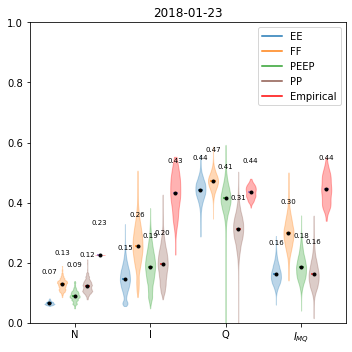

In [28]:
p1=Make_Plot_Of_Day('2018-01-23',DATA_NULL,DATA_EM)

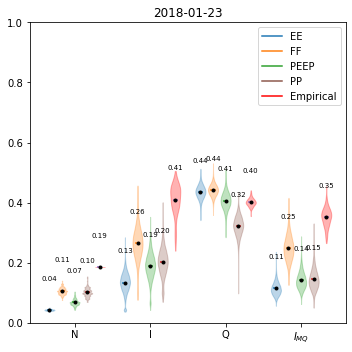

In [30]:
p2=Make_Plot_Of_Day('2018-01-25',DATA_NULL,DATA_EM)

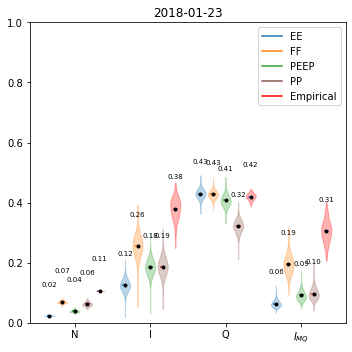

In [32]:
p3=Make_Plot_Of_Day('2018-02-05',DATA_NULL,DATA_EM)

# Make Time Series

In [25]:
def Make_One_Day(date,DATA_NULL,DATA_EM):
    # load the data on one day
    EE,FF,PEEP,PP=Date_Slice_data(date,DATA_NULL)
    N_em,  Q_em, I_em, I_MQ_em=Date_Slice_EM(date,DATA_EM) 

    # make gross list of the date
    N_EE,I_EE,Q_EE,I_MQ_EE=Make_Gross_list(EE)
    N_FF,I_FF,Q_FF,I_MQ_FF=Make_Gross_list(FF)
    N_PEEP,I_PEEP,Q_PEEP,I_MQ_PEEP=Make_Gross_list(PEEP)
    N_PP,I_PP,Q_PP,I_MQ_PP=Make_Gross_list(PP)
    
    

In [26]:
N_em={}
Q_em={}
I_em={}
I_MQ_em={}
N_EE={}
I_EE={}
Q_EE={}
I_MQ_EE={}
N_FF={}
I_FF={}
Q_FF={}
I_MQ_FF={}
N_PEEP={}
I_PEEP={}
Q_PEEP={}
I_MQ_PEEP={}
N_PP={}
I_PP={}
Q_PP={}
I_MQ_PP={}

for date in datelist:
    
    EE,FF,PEEP,PP=Date_Slice_data(date,DATA_NULL)
    N_em[date],  Q_em[date], I_em[date], I_MQ_em[date]=Date_Slice_EM(date,DATA_EM) 

    # make gross list of the date
    N_EE[date],I_EE[date],Q_EE[date],I_MQ_EE[date]=Make_Gross_list(EE)
    N_FF[date],I_FF[date],Q_FF[date],I_MQ_FF[date]=Make_Gross_list(FF)
    N_PEEP[date],I_PEEP[date],Q_PEEP[date],I_MQ_PEEP[date]=Make_Gross_list(PEEP)
    N_PP[date],I_PP[date],Q_PP[date],I_MQ_PP[date]=Make_Gross_list(PP)
    

In [27]:
# THE GRAPH BY TIME

In [134]:
def Draw_means_LINE(data,position,Color,Label):
    sample_means = np.mean(data, axis=1)

    # Create a violin plot with the roles of x and y switched
    bp=plt.violinplot(data, showmeans=True, showextrema=False,positions=position,  widths=0.4)

    # Add a vertical line or point for the mean of each sample
    for i, mean_val in enumerate(sample_means):
        plt.plot(position[i], mean_val, 'k.')  # 'ro' stands for red color, round marker
     #   plt.text(position[i], mean_val+0.1,  "{:.2f}".format(mean_val), color='black', ha='center',fontsize=7)
    plt.plot(position, sample_means, color=Color)
        
    set_box_color(bp, Color)     
    
    return plt

In [174]:
def MAKE_time_violin(dataEE,dataFF,dataPEEP,dataPP,dataEMPIRICAL,ticks):    
    plt.figure(figsize=(15,3))

    bp1 = Draw_means_LINE(dataEE,np.array(range(len(dataEE)))*3.0-1.0,'tab:blue','EE')
    bp2 = Draw_means_LINE(dataFF,np.array(range(len(dataFF)))*3.0-0.5,'tab:orange','FF')
    bp3 = Draw_means_LINE(dataPEEP,np.array(range(len(dataPEEP)))*3.0,'tab:green','PEEP')
    bp4 = Draw_means_LINE(dataPP,np.array(range(len(dataPP)))*3.0+0.5,'tab:brown','PP')
    bp5 = Draw_means_LINE(dataEMPIRICAL,np.array(range(len(dataPP)))*3.0+1.0,'red','Empirical')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='tab:blue', label='EE')
    plt.plot([], c='tab:orange', label='FF')
    plt.plot([], c='tab:green', label='PEEP')
    plt.plot([], c='tab:brown', label='PP')
    plt.plot([], c='red', label='Empirical')
    plt.legend(loc='upper center', ncol=5)

    plt.xticks(range(0, len(ticks) * 3, 3), ticks,rotation=30)
    #plt.xlim(-2, len(ticks)*3)
    plt.ylim(0, 1)
  #  plt.figure(figsize=(15,3))
    #plt.rcParams["figure.figsize"] = (20,3)
    plt.tight_layout()
    plt.title('NODF')
    plt.savefig('figure2_1.pdf')

In [136]:
def Make_Time_Visualization(dataEE,dataFF,dataPEEP,dataPP,dataEMPIRICAL,ticks):
    fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(10,12), sharey=True)
    axs[0].set_ylabel('EE')
    parts = axs[0].violinplot(dataEE, showmeans=False, showmedians=False, showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor('tab:blue')
        pc.set_edgecolor('tab:blue')
        pc.set_alpha(0.5)

    sample_means = np.mean(dataEE, axis=1)
    inds = np.arange(1, len(sample_means) + 1)
    axs[0].scatter(inds, sample_means, marker='.', color='k', s=30, zorder=3)
    axs[0].plot(inds, sample_means, marker='.', color='tab:blue')


    axs[1].set_ylabel('FF')
    parts = axs[1].violinplot(dataFF, showmeans=False, showmedians=False, showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor('tab:orange')
        pc.set_edgecolor('tab:orange')
        pc.set_alpha(0.5)

    sample_means = np.mean(dataFF, axis=1)
    inds = np.arange(1, len(sample_means) + 1)
    axs[1].scatter(inds, sample_means, marker='.', color='k', s=30, zorder=3)
    axs[1].plot(inds, sample_means, marker='.', color='tab:orange')

    axs[2].set_ylabel('PEEP')
    parts = axs[2].violinplot(dataPEEP, showmeans=False, showmedians=False, showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor('tab:green')
        pc.set_edgecolor('tab:green')
        pc.set_alpha(0.5)

    sample_means = np.mean(dataPEEP, axis=1)
    inds = np.arange(1, len(sample_means) + 1)
    axs[2].scatter(inds, sample_means, marker='.', color='k', s=30, zorder=3)
    axs[2].plot(inds, sample_means, marker='.', color='tab:green')


    axs[3].set_ylabel('PP')
    parts = axs[3].violinplot(dataPP, showmeans=False, showmedians=False, showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor('tab:brown')
        pc.set_edgecolor('tab:brown')
        pc.set_alpha(0.5)

    sample_means = np.mean(dataPP, axis=1)
    inds = np.arange(1, len(sample_means) + 1)
    axs[3].scatter(inds, sample_means, marker='.', color='k', s=30, zorder=3)
    axs[3].plot(inds, sample_means, marker='.', color='tab:brown')


    axs[4].set_ylabel('Empirical')
    parts = axs[4].violinplot(dataEMPIRICAL, showmeans=False, showmedians=False, showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor('red')
        pc.set_edgecolor('red')
        pc.set_alpha(0.5)

    sample_means = np.mean(dataEMPIRICAL, axis=1)
    inds = np.arange(1, len(sample_means) + 1)
    axs[4].scatter(inds, sample_means, marker='.', color='k', s=20, zorder=3)
    axs[4].plot(inds, sample_means, marker='.', color='red')

    for ax in axs:
        ax.set_xticks(np.arange(1, len(ticks) + 1), labels=ticks,rotation=30)
        ax.set_ylim(0,1)

    plt.subplots_adjust(hspace=0.5)
    plt.show()

In [137]:
def Stat_Time(EE,FF,PEEP,PP,em):
    dataEE=list(EE.values())
    dataFF=list(FF.values())
    dataPEEP=list(PEEP.values())
    dataPP=list(PP.values())
    dataEMPIRICAL=list(em.values())

    ticks_NULL=datelist
            
    MAKE_time_violin(dataEE,dataFF,dataPEEP,dataPP,dataEMPIRICAL,ticks_NULL)
    Make_Time_Visualization(dataEE,dataFF,dataPEEP,dataPP,dataEMPIRICAL,ticks_NULL)

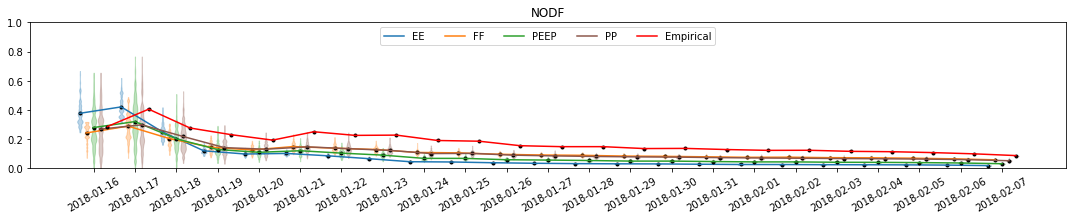

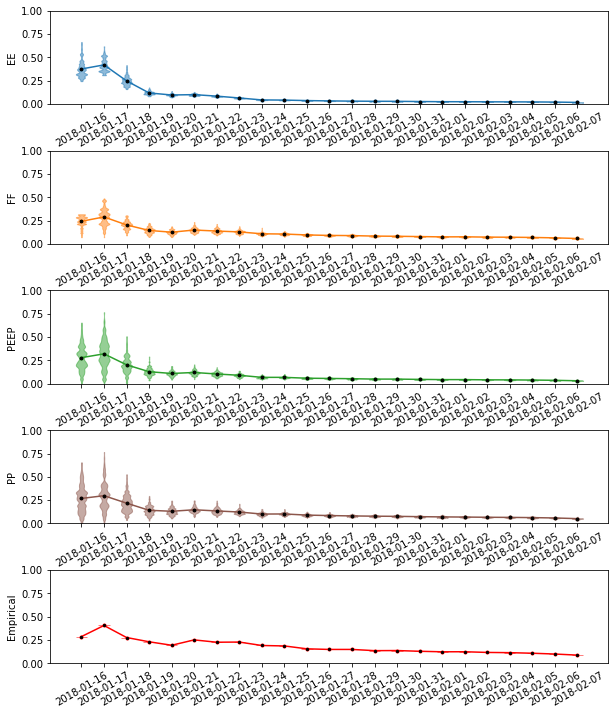

In [175]:
# NODF
# SAME OF ALL RANDOM
Stat_Time(N_EE,N_FF,N_PEEP,N_PP,N_em)


C:\Users\wyw25\anaconda3\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Users\wyw25\anaconda3\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


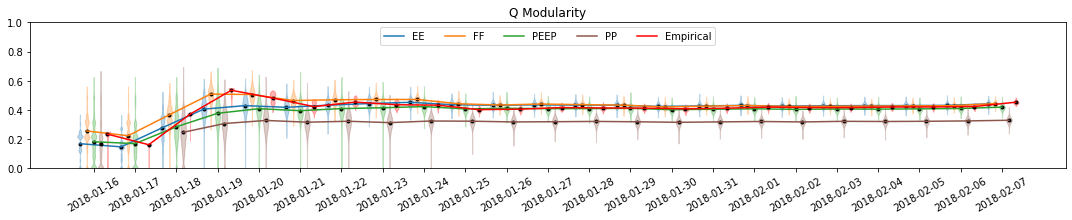

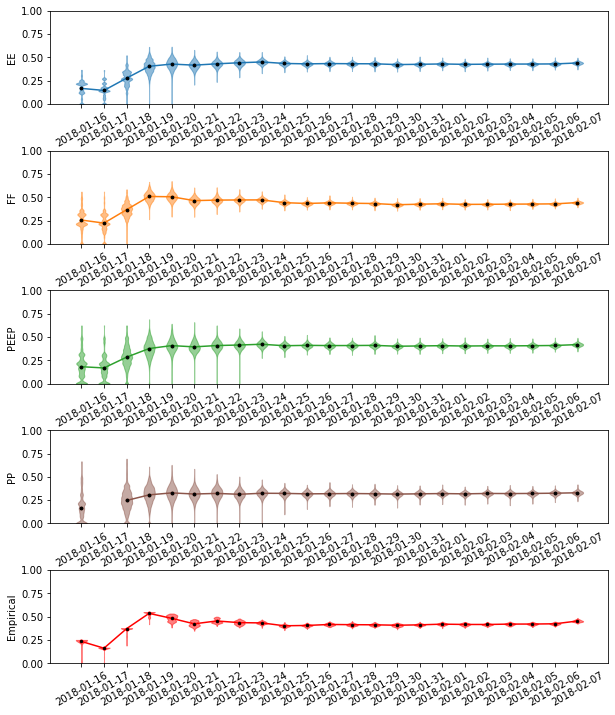

In [173]:
# Modularity
Stat_Time(Q_EE,Q_FF,Q_PEEP,Q_PP,Q_em)
    

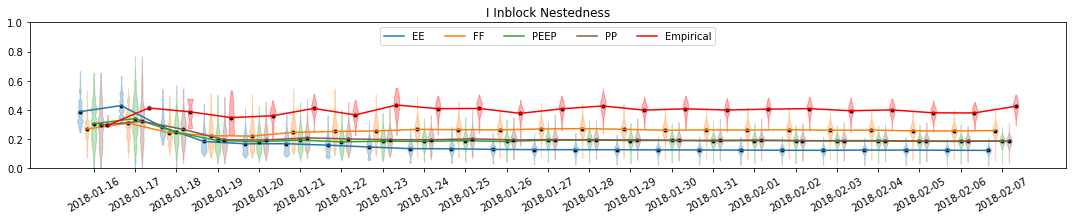

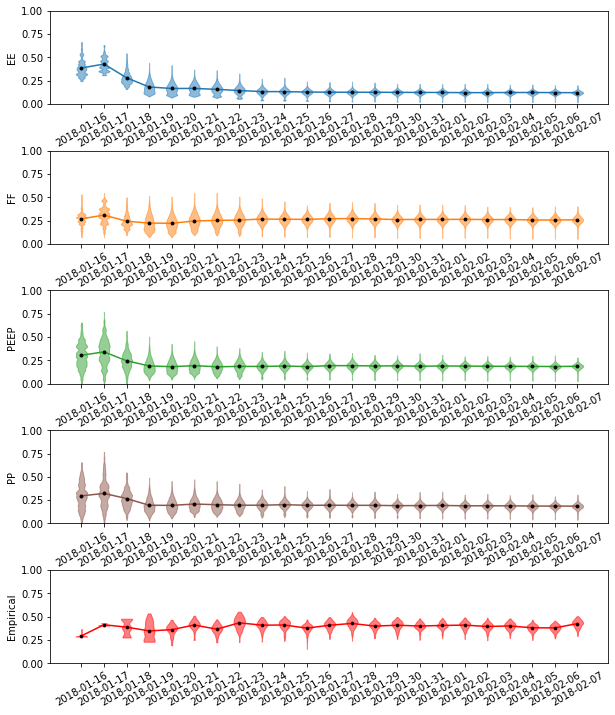

In [171]:
# Inblock Nestedness
Stat_Time(I_EE,I_FF,I_PEEP,I_PP,I_em)    


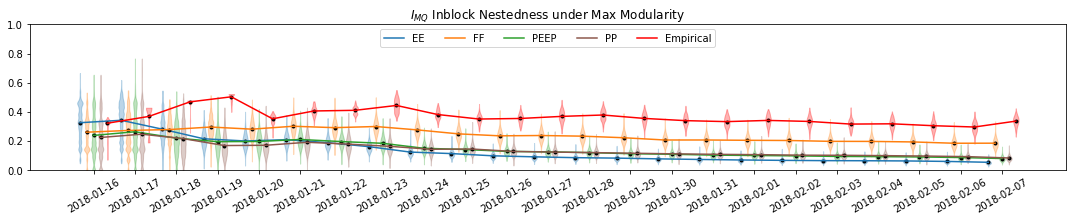

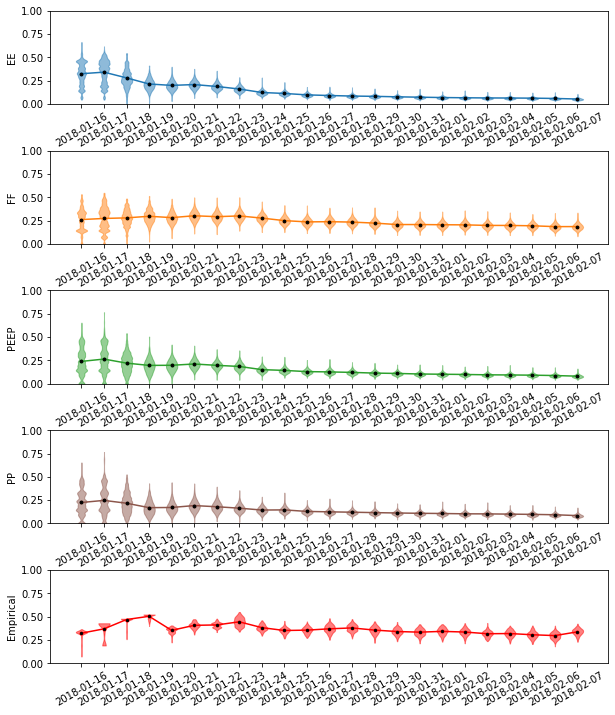

In [169]:
# Inblock Nestedness under Max Modularity
Stat_Time(I_MQ_EE,I_MQ_FF,I_MQ_PEEP,I_MQ_PP,I_MQ_em)


In [ ]:
# 200 for each null models 

In [ ]:
# repeat 200 for each